#### Libraries required to run woublet
numpy (http://www.numpy.org/)  
scipy (https://www.scipy.org/)  
sklearn (http://scikit-learn.org/stable/)  

#### Additional recommended libraries
annoy (https://github.com/spotify/annoy)  

#### Additional libraries required to run this notebook
matplotlib (https://matplotlib.org/)  
networkx (https://networkx.github.io/)  
fa2 (https://github.com/bhargavchippada/forceatlas2) 

#### Versions used
python 2.7.12  
numpy 1.11.3  
scipy 0.19.0  
sklearn 0.18.1  
annoy 1.8.0  
matplotlib 1.5.1  
networkx 1.9.1  
fa2 0.2  

In [1]:
%matplotlib inline
from doublet_detector import *
import scipy.io
import matplotlib.pyplot as plt
import os

### Download 8k PBMC data set from 10X Genomics
##### Only do this once

In [2]:
# Download raw data by navigating to the following URL in your web browser:
# http://cf.10xgenomics.com/samples/cell-exp/2.1.0/pbmc8k/pbmc8k_filtered_gene_bc_matrices.tar.gz

# Or use wget
!wget http://cf.10xgenomics.com/samples/cell-exp/2.1.0/pbmc8k/pbmc8k_filtered_gene_bc_matrices.tar.gz

--2018-03-06 19:36:55--  http://cf.10xgenomics.com/samples/cell-exp/2.1.0/pbmc8k/pbmc8k_filtered_gene_bc_matrices.tar.gz
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 13.33.35.188, 13.33.35.78, 13.33.35.64, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|13.33.35.188|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37558165 (36M) [application/x-tar]
Saving to: ‘pbmc8k_filtered_gene_bc_matrices.tar.gz’

pbmc8k_filtered_gen 100%[===================>]  35.82M  10.5MB/s    in 4.5s    

2018-03-06 19:37:00 (7.97 MB/s) - ‘pbmc8k_filtered_gene_bc_matrices.tar.gz’ saved [37558165/37558165]



In [3]:
# Uncompress 
!tar xfz pbmc8k_filtered_gene_bc_matrices.tar.gz

### Load counts matrix and gene list

In [4]:
# path to counts matrix and gene list
input_dir = 'filtered_gene_bc_matrices/GRCh38/'

#### The first time this is run, the counts matrix is loaded from the mtx file. An npz file is saved for fast loading in the future.

In [5]:
# The raw counts matrix (E) should be a scipy sparse CSC matrix
# with cells as rows and genes as columns

if os.path.isfile(input_dir + '/matrix.npz'):
    E = scipy.sparse.load_npz(input_dir + '/matrix.npz')
else:
    E = scipy.io.mmread(input_dir + '/matrix.mtx').T.tocsc()
    scipy.sparse.save_npz(input_dir + '/matrix.npz', E, compressed=True)

print E.shape

(8381, 33694)


#### Load gene names, appending "\__1", "\__2", etc. to genes that appear more than once.

In [6]:
genes = np.array(load_genes(input_dir + 'genes.tsv', delimiter='\t', column=1))

### Check that the distribution of total counts per cell looks reasonable

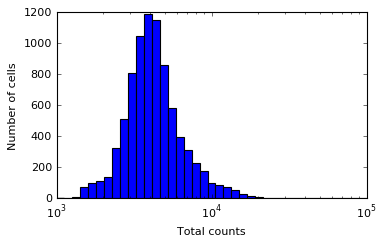

In [7]:
total_counts = E.sum(1).A.squeeze()

fig, ax = plt.subplots(figsize = (5, 3))
ax.hist(total_counts, bins = np.logspace(3, 5, 40))
ax.set_xscale('log')
ax.set_xlabel('Total counts')
ax.set_ylabel('Number of cells')


### Cell-level normalization by total counts

In [8]:
E_norm = tot_counts_norm(E)[0]

### Filter genes based on expression level and variability

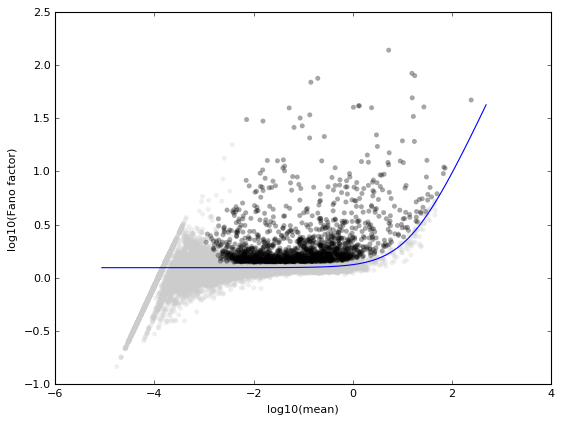

1697 genes


In [9]:
gene_filter = filter_genes(E_norm, min_vscore_pctl=85, min_counts=2, min_cells=3, show_vscore_plot=True)
print len(gene_filter), 'genes'

### Run PCA

In [10]:
pca = get_pca(E_norm[:,gene_filter], numpc = 50, keep_sparse = True, normalize = True)

### Calculate doublet scores

In [11]:
# Outputs: 
#  doub_score: doublet scores for each cell
#  doub_score_sim: doublet scores for simulated doublets; useful for determining threshold for calling doublets

doub_score, doub_score_sim = woublet(precomputed_pca=pca, 
                                     exp_doub_rate = 0.1,
                                     total_counts=total_counts,
                                     sim_doublet_ratio=3,
                                     k=50, 
                                     use_approx_nn=True
                                    )

Simulating doublets
Running KNN classifier
Using approximate nearest neighbor search
kNN graph built in 23.841 sec


### Check out the doublet score distribution. Manually set a threshold between the two peaks of the simulated doublet histogram.

402/8381 = 4.80% of cells are predicted doublets.
63% of doublets are predicted to be detectable.


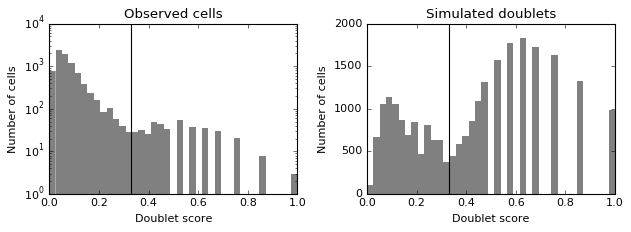

In [12]:
# Adjust doub_threshold to lie in the trough between the two peaks of simulated doublet histogram
doub_threshold = 0.33


######

called_doubs = doub_score > doub_threshold
print '%i/%i = %.2f%s of cells are predicted doublets.' %(sum(called_doubs), len(called_doubs), 
                                                          100 * sum(called_doubs) / float(len(called_doubs)), 
                                                          '%')

called_doubs_sim = doub_score_sim > doub_threshold
print '%.0f%s of doublets are predicted to be detectable.' %(100 * sum(called_doubs_sim) / float(len(called_doubs_sim)),
                                                             '%')


fig, axs = plt.subplots(1, 2, figsize = (8, 3))

ax = axs[0]
ax.hist(doub_score, np.linspace(0, 1, 40), color = 'gray', linewidth = 0)
ax.set_yscale('log')
ax.plot([doub_threshold, doub_threshold], ax.get_ylim(), c = 'black')
ax.set_title('Observed cells')
ax.set_xlabel('Doublet score')
ax.set_ylabel('Number of cells')

ax = axs[1]
ax.hist(doub_score_sim, np.linspace(0, 1, 40), color = 'gray', linewidth = 0)
ax.plot([doub_threshold, doub_threshold], ax.get_ylim(), c='black')
ax.set_title('Simulated doublets')
ax.set_xlabel('Doublet score')
ax.set_ylabel('Number of cells')

fig.tight_layout()



### We should check that the predicted doublets co-localize in clusters or on a 2-D visualization. We'll use a force-directed graph layout.

#### First, build a k-nearest-neighbor graph in PCA space

In [13]:
edges = get_knn_graph(pca, k=4, approx=False)[0]

Using sklearn NearestNeighbors
kNN graph built in 7.551 sec


#### Now run the force layout algorithm (ForceAtlas2)

In [14]:
force_coords = get_force_layout(edges, pca.shape[0], n_iter=2000, verbose=True, 
                                gravity = 0.05, jitterTolerance=0.1)

100%|██████████| 2000/2000 [04:04<00:00,  8.16it/s]

('BarnesHut Approximation', ' took ', '127.99', ' seconds')
('Repulsion forces', ' took ', '96.24', ' seconds')
('Gravitational forces', ' took ', '0.99', ' seconds')
('Attraction forces', ' took ', '1.53', ' seconds')
('AdjustSpeedAndApplyForces step', ' took ', '4.92', ' seconds')


### Plot doublet scores and predicted doublets on the force layout

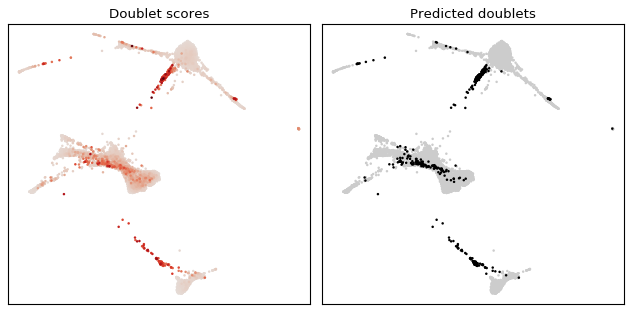

In [15]:
x = force_coords[:,0]
y = force_coords[:,1]

fig, axs = plt.subplots(1, 2, figsize = (8, 4))

coldat = np.copy(doub_score)
o = np.argsort(coldat)
# o = np.arange(coldat)
ax = axs[0]
ax.scatter(x[o], y[o], s = 5, c = coldat[o], alpha = 1, edgecolors = '', cmap = darken_cmap(plt.cm.Reds, 0.9))
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim(min(x)-500, max(x)+500)
ax.set_ylim(min(y)-500, max(y)+500)
ax.set_title('Doublet scores')

ax = axs[1]
coldat = np.copy(called_doubs)
o = np.argsort(coldat)
# o = np.arange(coldat)
ax.scatter(x[o], y[o], s = 5, c = coldat[o], alpha = 1, edgecolors = '', cmap = custom_cmap([[.8,.8,.8], [0,0,0]]))
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim(min(x)-500, max(x)+500)
ax.set_ylim(min(y)-500, max(y)+500)
ax.set_title('Predicted doublets')

fig.tight_layout()

### Orient yourself by plotting some marker genes on the force layout

In [16]:
marker_genes = ['CD3D', 'NKG7', 'CD79A', 'LYZ', 'FCGR3A', 'FCER1A', 'IL3RA', 'PPBP']

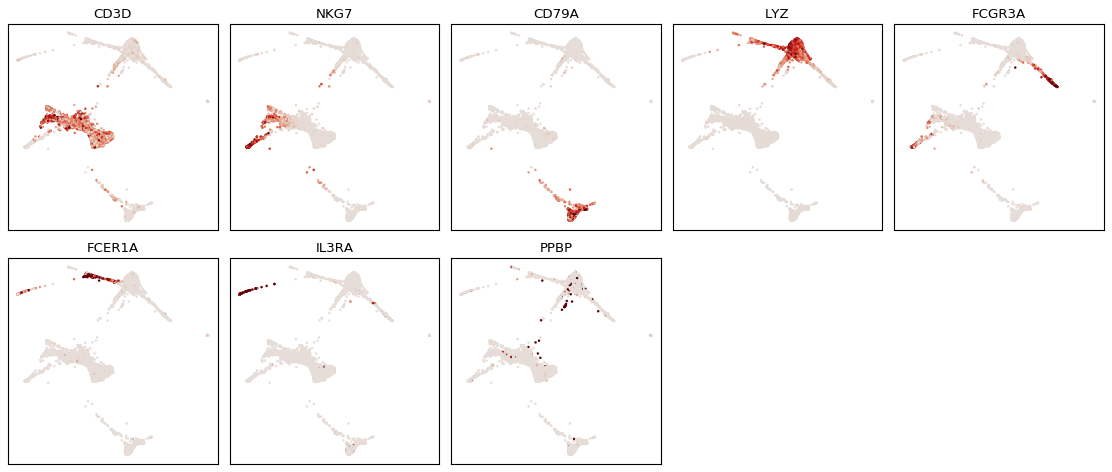

In [17]:
genes_to_plot = marker_genes

x = force_coords[:,0]
y = force_coords[:,1]

ncol = 5
nrow = len(genes_to_plot) / ncol + 1
fig = plt.figure(figsize = (14.0 / 5 * ncol, 3 * nrow))
for iG, g in enumerate(genes_to_plot):
    ax = plt.subplot(nrow, ncol, iG + 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(g)
    
    k = list(genes).index(g)
    color_dat = E_norm[:,k].A.squeeze()
    
    ax.scatter(x, y, c = color_dat, s = 5, cmap = darken_cmap(plt.cm.Reds,0.9), 
               vmax = np.percentile(color_dat, 99), edgecolors='')
    
fig.tight_layout()